In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fingernail-all/FingerNail_Features.xlsx
/kaggle/input/fingernail-all/Fingernail Masked/Fingernail Masked/1709974143530.jpg
/kaggle/input/fingernail-all/Fingernail Masked/Fingernail Masked/1710051134288.jpg
/kaggle/input/fingernail-all/Fingernail Masked/Fingernail Masked/1709800917321.jpg
/kaggle/input/fingernail-all/Fingernail Masked/Fingernail Masked/1709976901316.jpg
/kaggle/input/fingernail-all/Fingernail Masked/Fingernail Masked/1709723206678.jpg
/kaggle/input/fingernail-all/Fingernail Masked/Fingernail Masked/1709795312517.jpg
/kaggle/input/fingernail-all/Fingernail Masked/Fingernail Masked/1709720647227.jpg
/kaggle/input/fingernail-all/Fingernail Masked/Fingernail Masked/1710059890678.jpg
/kaggle/input/fingernail-all/Fingernail Masked/Fingernail Masked/1709636926027.jpg
/kaggle/input/fingernail-all/Fingernail Masked/Fingernail Masked/1710059288351.jpg
/kaggle/input/fingernail-all/Fingernail Masked/Fingernail Masked/1709985772004.jpg
/kaggle/input/fingernail-all/Fing

In [1]:
import pandas as pd 
df = pd.read_excel('/kaggle/input/fingernail-all/FingerNail_Features.xlsx')
df = df[['Image_Name','Hb Value']]
df.head()

,Image_Name,Hb Value
0,1709617374918.jpg,11.5
1,1709617703730.jpg,11.6
2,1709618658975.jpg,11.1
3,1709619498294.jpg,12.1
4,1709620017738.jpg,12.2


In [2]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, test_size=0.15, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.176, random_state=42)

In [3]:
print('train_df shape',train_df.shape)
print('test_df shape',test_df.shape)
print('tval_df shape',val_df.shape)

train_df shape (291, 2)
test_df shape (63, 2)
tval_df shape (63, 2)


In [4]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from PIL import Image

def load_image_and_label(image_file, label):
    image = tf.io.read_file(image_file)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [224, 224])  # ResNet50 expects 224x224
    # Scale pixel values [0, 1] or standardize them
    image = image / 255.0
    return image, label

def create_tf_dataset(df, images_folder, batch_size=8, shuffle=True):
    # Construct full paths to images
    image_paths = [os.path.join(images_folder, img) for img in df['Image_Name'].values]
    labels = df['Hb Value'].values.astype(np.float32)

    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    dataset = dataset.map(load_image_and_label, num_parallel_calls=tf.data.AUTOTUNE)
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(df))
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

# Create datasets
train_ds = create_tf_dataset(train_df, "/kaggle/input/fingernail-all/Fingernail Masked/Fingernail Masked", batch_size=16, shuffle=True)
val_ds   = create_tf_dataset(val_df,   "/kaggle/input/fingernail-all/Fingernail Masked/Fingernail Masked", batch_size=16, shuffle=False)
test_ds  = create_tf_dataset(test_df,  "/kaggle/input/fingernail-all/Fingernail Masked/Fingernail Masked", batch_size=16, shuffle=False)


In [5]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model

def build_model(input_shape=(224, 224, 3)):
    # Load ResNet50 without the top classification layers
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)


    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    # Add your own fully connected layers if desired
    # x = Dense(128, activation='relu')(x)
    # x = Dropout(0.3)(x)

    # Final regression output (1 dimension: predicted Hb)
    predictions = Dense(1, activation='linear')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    return model


In [8]:
model = build_model(input_shape=(224, 224, 3))
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='mean_squared_error',  # or 'mae'
    metrics=[tf.keras.metrics.MeanAbsoluteError()]
)


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [9]:
epochs = 100
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)


Epoch 1/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 18s 456ms/step - loss: 130.7481 - mean_absolute_error: 11.2747 - val_loss: 106.1734 - val_mean_absolute_error: 10.1265
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 120.7137 - mean_absolute_error: 10.8305 - val_loss: 98.0760 - val_mean_absolute_error: 9.7186
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 111.3468 - mean_absolute_error: 10.4086 - val_loss: 90.4325 - val_mean_absolute_error: 9.3172
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 234ms/step - loss: 104.2012 - mean_absolute_error: 10.0404 - val_loss: 83.2659 - val_mean_absolute_error: 8.9245
Epoch 5/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 96.1007 - mean_absolute_error: 9.6239 - val_loss: 76.5213 - val_mean_absolute_error: 8.5384
Epoch 6/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 89.6535 - mean_absolute_error: 9.2913 - val_loss: 70.1749 - val_mean_absolute_error: 8.1585
Epoch 7/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 82.1132 - mean_

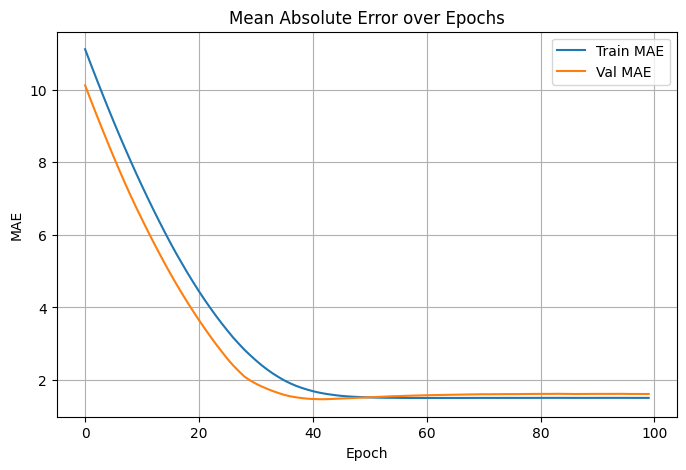

In [10]:
import matplotlib.pyplot as plt

# 1. Retrieve MAE values
train_mae = history.history['mean_absolute_error']       # Training MAE per epoch
val_mae   = history.history['val_mean_absolute_error']   # Validation MAE per epoch

# 2. Plot
plt.figure(figsize=(8, 5))
plt.plot(train_mae, label='Train MAE')
plt.plot(val_mae, label='Val MAE')
plt.title('Mean Absolute Error over Epochs')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)
plt.show()


In [12]:
model.save('resnet-50-Trainable_False_FingerNail.h5')

In [13]:
test_loss, test_mae = model.evaluate(test_ds)
print("Test MAE:", test_mae)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 3.7820 - mean_absolute_error: 1.6344
Test MAE: 1.6405099630355835


In [14]:
def build_model(input_shape=(224, 224, 3)):
    # Load ResNet50 without the top classification layers
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)


    for layer in base_model.layers:
        layer.trainable = True

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    # Add your own fully connected layers if desired
    # x = Dense(128, activation='relu')(x)
    # x = Dropout(0.3)(x)

    # Final regression output (1 dimension: predicted Hb)
    predictions = Dense(1, activation='linear')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    return model


In [15]:
model = build_model(input_shape=(224, 224, 3))
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='mean_squared_error',  # or 'mae'
    metrics=[tf.keras.metrics.MeanAbsoluteError()]
)


In [16]:
epochs = 100
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)


Epoch 1/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step - loss: 53.7518 - mean_absolute_error: 6.1927 - val_loss: 83.3189 - val_mean_absolute_error: 8.9274
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - loss: 5.6692 - mean_absolute_error: 1.8978 - val_loss: 92.2427 - val_mean_absolute_error: 9.4138
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - loss: 2.6728 - mean_absolute_error: 1.2727 - val_loss: 30.7713 - val_mean_absolute_error: 5.2746
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - loss: 1.3537 - mean_absolute_error: 0.9049 - val_loss: 22.4850 - val_mean_absolute_error: 4.4348
Epoch 5/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - loss: 0.8589 - mean_absolute_error: 0.7339 - val_loss: 35.0241 - val_mean_absolute_error: 5.6554
Epoch 6/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - loss: 0.5983 - mean_absolute_error: 0.6073 - val_loss: 40.6931 - val_mean_absolute_error: 6.1248
Epoch 7/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - loss: 0.6338 - mean_absolute_error: 0.64

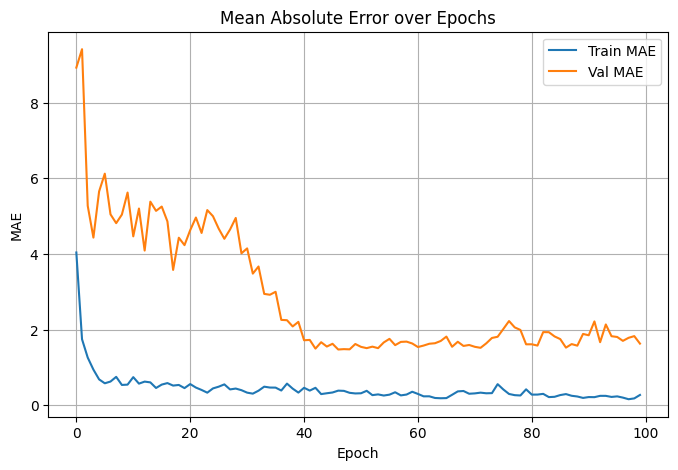

In [17]:

# 1. Retrieve MAE values
train_mae = history.history['mean_absolute_error']       # Training MAE per epoch
val_mae   = history.history['val_mean_absolute_error']   # Validation MAE per epoch

# 2. Plot
plt.figure(figsize=(8, 5))
plt.plot(train_mae, label='Train MAE')
plt.plot(val_mae, label='Val MAE')
plt.title('Mean Absolute Error over Epochs')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)
plt.show()


In [18]:
test_loss, test_mae = model.evaluate(test_ds)
print("Test MAE:", test_mae)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 3.6709 - mean_absolute_error: 1.4795
Test MAE: 1.4747205972671509


In [19]:
model.save('resnet-50-Trainable_True_FingerNail.h5')

In [8]:
from tensorflow.keras.layers import Dropout
def build_model(input_shape=(224, 224, 3)):
    # Load ResNet50 without the top classification layers
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)


    for layer in base_model.layers:
        layer.trainable = True

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    # Add your own fully connected layers if desired
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)

    # Final regression output (1 dimension: predicted Hb)
    predictions = Dense(1, activation='linear')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    return model


In [9]:
model = build_model(input_shape=(224, 224, 3))
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='mean_squared_error',  # or 'mae'
    metrics=[tf.keras.metrics.MeanAbsoluteError()]
)


In [10]:
epochs = 100
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)


Epoch 1/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 86s 2s/step - loss: 66.3951 - mean_absolute_error: 7.1024 - val_loss: 95.4310 - val_mean_absolute_error: 9.5824
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - loss: 8.0046 - mean_absolute_error: 2.3016 - val_loss: 106.1463 - val_mean_absolute_error: 10.1257
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step - loss: 6.0378 - mean_absolute_error: 1.9875 - val_loss: 106.1563 - val_mean_absolute_error: 10.1261
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - loss: 3.9635 - mean_absolute_error: 1.5546 - val_loss: 97.8170 - val_mean_absolute_error: 9.7057
Epoch 5/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - loss: 3.2986 - mean_absolute_error: 1.4588 - val_loss: 81.3099 - val_mean_absolute_error: 8.8143
Epoch 6/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - loss: 2.5531 - mean_absolute_error: 1.2658 - val_loss: 50.4775 - val_mean_absolute_error: 6.8572
Epoch 7/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - loss: 2.6406 - mean_absolute_error

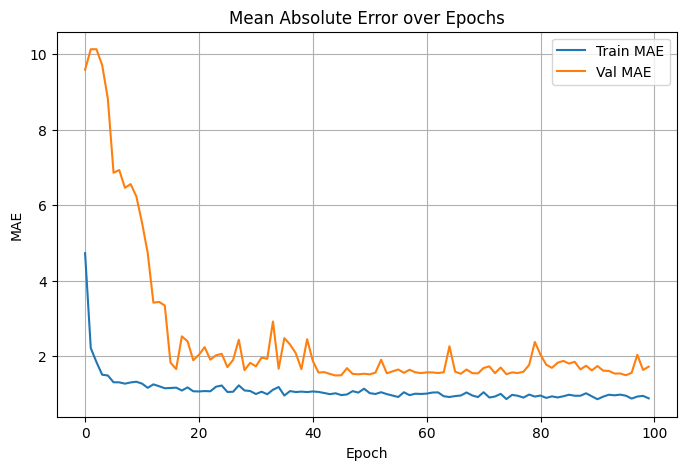

In [12]:
import matplotlib.pyplot as plt

# 1. Retrieve MAE values
train_mae = history.history['mean_absolute_error']       # Training MAE per epoch
val_mae   = history.history['val_mean_absolute_error']   # Validation MAE per epoch

# 2. Plot
plt.figure(figsize=(8, 5))
plt.plot(train_mae, label='Train MAE')
plt.plot(val_mae, label='Val MAE')
plt.title('Mean Absolute Error over Epochs')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)
plt.show()


In [13]:
test_loss, test_mae = model.evaluate(test_ds)
print("Test MAE:", test_mae)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 4.1684 - mean_absolute_error: 1.6119
Test MAE: 1.5984233617782593


In [14]:
model.save('resnet-50-trainable-true-custom-fingernail.h5')